In [13]:
import pandas as pd 
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pickle

In [11]:
dim_reduced_df = pd.read_csv('../data/fix/')

In [12]:
dim_reduced_df.shape

(700, 50)

In [7]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Financial indicators to forecast
financial_indicators = [
    '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', 
    '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 
    'OECD_CLI_index', 'CSI_index', 'gdp_per_capita'
]

# Recession probability target columns to exclude from exog
recession_targets = [
    'recession_probability', '1_month_recession_probability', 
    '3_month_recession_probability', '6_month_recession_probability'
]

def prepare_data_split(df, date_col='date', split_year=2020):
    df[date_col] = pd.to_datetime(df[date_col])
    df_sorted = df.sort_values(date_col).reset_index(drop=True)
    train_data = df_sorted[df_sorted[date_col].dt.year < split_year].copy()
    test_data = df_sorted[df_sorted[date_col].dt.year >= split_year].copy()
    print(f"Training data: {len(train_data)} observations ({train_data[date_col].min()} to {train_data[date_col].max()})")
    print(f"Test data: {len(test_data)} observations ({test_data[date_col].min()} to {test_data[date_col].max()})")
    return train_data, test_data

def check_stationarity(series, series_name):
    result = adfuller(series.dropna())
    print(f'\n{series_name} Stationarity Test:')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    if result[1] <= 0.05:
        print("Series is stationary")
        return True
    else:
        print("Series is non-stationary")
        return False

def auto_arima_with_exog(series, exog, max_p=3, max_d=2, max_q=3):
    best_aic = float('inf')
    best_order = None
    best_model = None

    # Clean exog
    exog = exog.fillna(method='ffill').fillna(method='bfill')
    exog = exog.replace([np.inf, -np.inf], np.nan)
    exog = exog.fillna(method='ffill').fillna(method='bfill')
    exog = exog.loc[:, exog.nunique() > 1]  # Remove constant columns
    
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    print(f"Trying ARIMA order: ({p},{d},{q})")
                    model = ARIMA(series, order=(p, d, q), exog=exog, trend='n')  # No constant trend
                    fitted_model = model.fit()
                    print(f"  Success: AIC = {fitted_model.aic}")
                    if fitted_model.aic < best_aic:
                        best_aic = fitted_model.aic
                        best_order = (p, d, q)
                        best_model = fitted_model
                except Exception as e:
                    print(f"  Failed ARIMA order ({p},{d},{q}): {e}")
                    continue

    return best_model, best_order, best_aic


def forecast_indicator_with_exog(train_df, test_df, indicator_name, forecast_steps=None):
    print(f"\n{'='*50}")
    print(f"Forecasting: {indicator_name}")
    print(f"{'='*50}")

    train_series = train_df[indicator_name].dropna()
    test_series = test_df[indicator_name].dropna()

    # Prepare exogenous variables: exclude target columns and the indicator itself
    features_to_exclude = recession_targets + financial_indicators
    train_exog = train_df.drop(columns=features_to_exclude, errors='ignore')
    test_exog = test_df.drop(columns=features_to_exclude, errors='ignore')

    # Align exog and endog indices
    train_exog = train_exog.loc[train_series.index]
    test_exog = test_exog.loc[test_series.index]

    # Clean exog
    train_exog = train_exog.fillna(method='ffill').fillna(method='bfill')
    train_exog = train_exog.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(method='bfill')
    train_exog = train_exog.loc[:, train_exog.nunique() > 1]  # Remove constant columns

    test_exog = test_exog.fillna(method='ffill').fillna(method='bfill')
    test_exog = test_exog.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(method='bfill')

    # Ensure test_exog columns are exactly the same as train_exog columns, in the same order
    test_exog = test_exog[train_exog.columns]

    # Now set forecast_steps properly
    if forecast_steps is None:
        forecast_steps = min(len(test_series), len(test_exog))

    # Stationarity test
    check_stationarity(train_series, indicator_name)

    # Fit ARIMA
    try:
        model, order, aic = auto_arima_with_exog(train_series, train_exog)
        print(f"Best ARIMA order: {order}")
        print(f"AIC: {aic:.2f}")

        forecast_result = model.forecast(steps=forecast_steps, exog=test_exog.iloc[:forecast_steps])
        forecast_ci = model.get_forecast(steps=forecast_steps, exog=test_exog.iloc[:forecast_steps]).conf_int()

        results = {
            'model': model,
            'order': order,
            'aic': aic,
            'forecast': forecast_result,
            'forecast_lower': forecast_ci.iloc[:, 0],
            'forecast_upper': forecast_ci.iloc[:, 1],
            'actual': test_series.iloc[:forecast_steps]
        }

        actual_values = test_series.iloc[:forecast_steps]
        mae = np.mean(np.abs(forecast_result - actual_values))
        rmse = np.sqrt(np.mean((forecast_result - actual_values) ** 2))
        mape = np.mean(np.abs((actual_values - forecast_result) / actual_values)) * 100

        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAPE: {mape:.2f}%")

        results.update({'mae': mae, 'rmse': rmse, 'mape': mape})

        return results

    except Exception as e:
        print(f"Error fitting ARIMA for {indicator_name}: {str(e)}")
        return None



def plot_forecast_results(results, indicator_name, train_series, test_dates):
    if results is None:
        return
    
    plt.figure(figsize=(12, 6))
    train_plot = train_series.tail(24)
    plt.plot(train_plot.index, train_plot.values, label='Training Data', color='blue')
    
    actual = results['actual']
    forecast_dates = test_dates[:len(actual)]
    plt.plot(forecast_dates, actual.values, label='Actual', color='green', linewidth=2)
    
    forecast = results['forecast']
    forecast_dates_full = test_dates[:len(forecast)]
    plt.plot(forecast_dates_full, forecast, label='Forecast', color='red', linewidth=2)
    
    plt.fill_between(forecast_dates_full, 
                     results['forecast_lower'], 
                     results['forecast_upper'], 
                     alpha=0.3, color='red', label='95% Confidence Interval')
    
    plt.title(f'{indicator_name} - ARIMA Forecast with Exogenous Variables')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def run_time_series_forecasting(df, financial_indicators, plot_results=True):
    train_data, test_data = prepare_data_split(df)
    
    all_results = {}
    forecasted_values = pd.DataFrame()
    forecasted_values['date'] = test_data['date'].reset_index(drop=True)
    
    for indicator in financial_indicators:
        if indicator not in df.columns:
            print(f"Warning: {indicator} not found in dataframe")
            continue
        
        results = forecast_indicator_with_exog(train_data.set_index('date'), test_data.set_index('date'), indicator)
        
        if results is not None:
            # Align forecasts to the test index length
            forecast_series = pd.Series(
                results['forecast'].values,
                index=test_data['date'][:len(results['forecast'])].values
            )
            lower_series = pd.Series(
                results['forecast_lower'].values,
                index=test_data['date'][:len(results['forecast_lower'])].values
            )
            upper_series = pd.Series(
                results['forecast_upper'].values,
                index=test_data['date'][:len(results['forecast_upper'])].values
            )

            # Ensure forecasted_values also uses the same date index
            forecasted_values.set_index('date', inplace=True)

            forecasted_values.loc[forecast_series.index, f'{indicator}_forecast'] = forecast_series.values
            forecasted_values.loc[lower_series.index, f'{indicator}_lower'] = lower_series.values
            forecasted_values.loc[upper_series.index, f'{indicator}_upper'] = upper_series.values

            forecasted_values.reset_index(inplace=True)


            # Save results
            all_results[indicator] = results

            # Plot if requested
            if plot_results:
                plot_forecast_results(
                    results,
                    indicator,
                    train_data.set_index('date')[indicator],
                    test_data['date']
                )
    
    return all_results, forecasted_values, train_data, test_data


Training data: 635 observations (1967-02-01 00:00:00 to 2019-12-01 00:00:00)
Test data: 65 observations (2020-01-01 00:00:00 to 2025-05-01 00:00:00)

Forecasting: 1_year_rate

1_year_rate Stationarity Test:
ADF Statistic: -1.464638
p-value: 0.550926
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 2497.0414142455943
Trying ARIMA order: (0,0,1)
  Success: AIC = 1991.2697959420702
Trying ARIMA order: (0,0,2)
  Success: AIC = 1856.4137083714559
Trying ARIMA order: (0,0,3)
  Success: AIC = 1698.0839225100794
Trying ARIMA order: (0,1,0)
  Success: AIC = 474.2703328531404
Trying ARIMA order: (0,1,1)
  Success: AIC = 427.3014743398779
Trying ARIMA order: (0,1,2)
  Success: AIC = 427.88146711005584
Trying ARIMA order: (0,1,3)
  Success: AIC = 428.43310572966743
Trying ARIMA order: (0,2,0)
  Success: AIC = 657.4212429335938
Trying ARIMA order: (0,2,1)
  Success: AIC = 530.7941424222388
Trying ARIMA order: (0,2,2)
  Success: AIC = 469.70049361975526
Trying ARIMA order: (0,2,

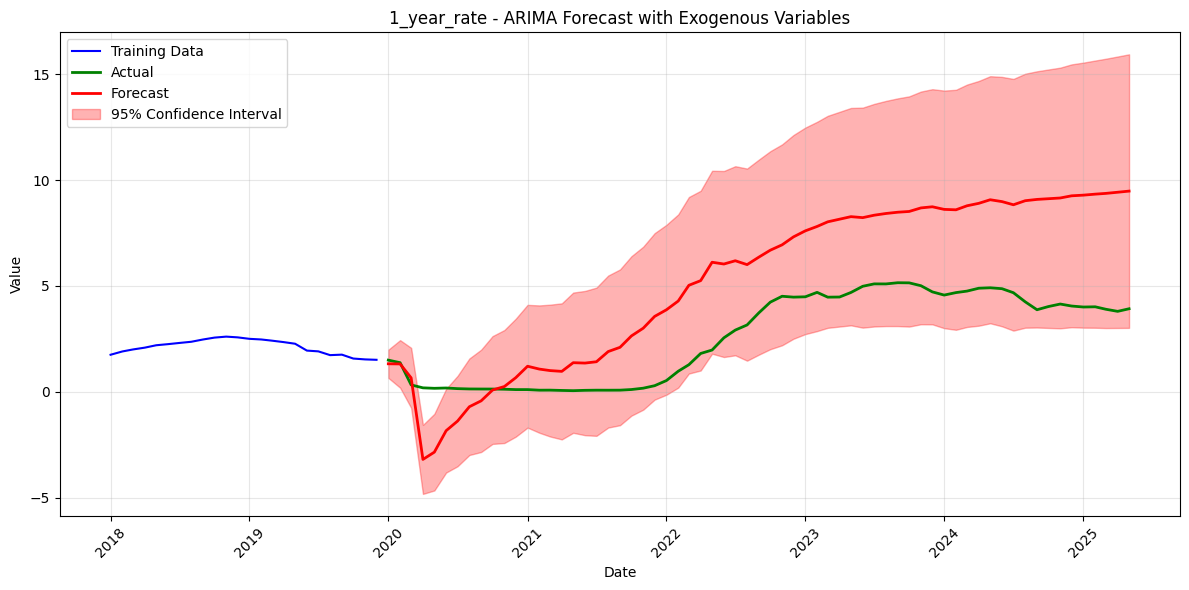


Forecasting: 3_months_rate

3_months_rate Stationarity Test:
ADF Statistic: -1.869398
p-value: 0.346591
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 2759.423656668703
Trying ARIMA order: (0,0,1)
  Success: AIC = 2388.8442244392713
Trying ARIMA order: (0,0,2)
  Success: AIC = 2238.4076191839586
Trying ARIMA order: (0,0,3)
  Success: AIC = 1969.4036089853219
Trying ARIMA order: (0,1,0)
  Success: AIC = 686.0779109478614
Trying ARIMA order: (0,1,1)
  Success: AIC = 635.7393672281905
Trying ARIMA order: (0,1,2)
  Success: AIC = 636.9510511505474
Trying ARIMA order: (0,1,3)
  Success: AIC = 638.5252429411253
Trying ARIMA order: (0,2,0)
  Success: AIC = 911.4937446233
Trying ARIMA order: (0,2,1)
  Success: AIC = 714.7472115097003
Trying ARIMA order: (0,2,2)
  Success: AIC = 667.2315122447717
Trying ARIMA order: (0,2,3)
  Success: AIC = 666.7923357271583
Trying ARIMA order: (1,0,0)
  Success: AIC = 1329.1704858053185
Trying ARIMA order: (1,0,1)
  Success: AIC = 1262.

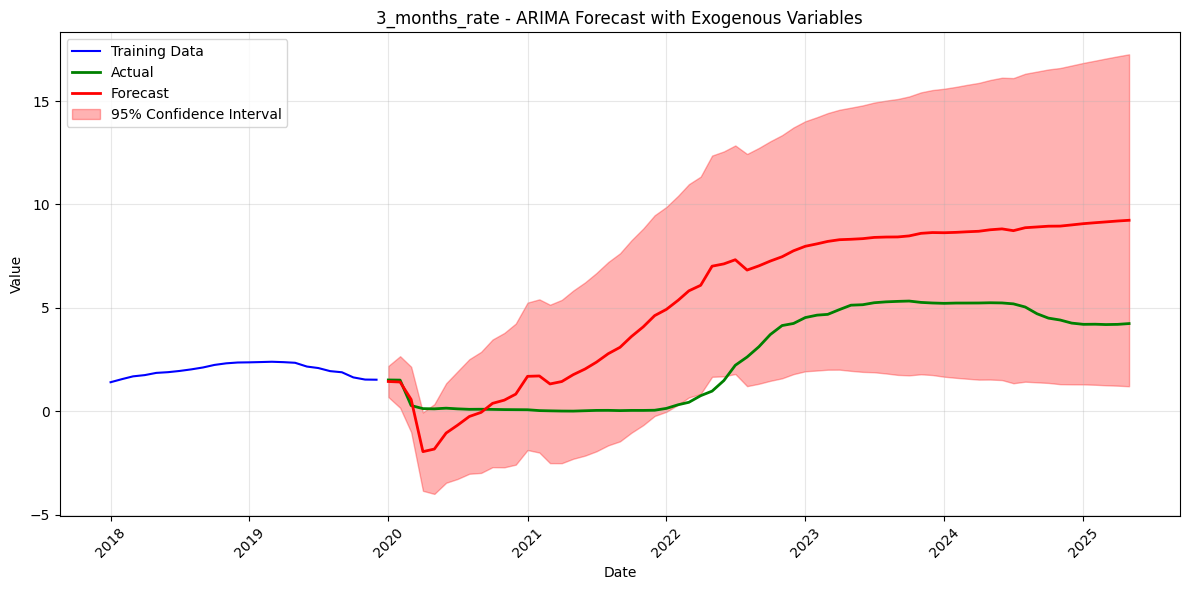


Forecasting: 6_months_rate

6_months_rate Stationarity Test:
ADF Statistic: -1.740531
p-value: 0.410360
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 2715.129874767057
Trying ARIMA order: (0,0,1)
  Success: AIC = 2357.2211484775253
Trying ARIMA order: (0,0,2)
  Success: AIC = 2205.6300156874713
Trying ARIMA order: (0,0,3)
  Success: AIC = 1887.4439479260632
Trying ARIMA order: (0,1,0)
  Success: AIC = 595.731262716629
Trying ARIMA order: (0,1,1)
  Success: AIC = 547.038578921186
Trying ARIMA order: (0,1,2)
  Success: AIC = 549.048230566338
Trying ARIMA order: (0,1,3)
  Success: AIC = 549.3085241189012
Trying ARIMA order: (0,2,0)
  Success: AIC = 814.2433100801037
Trying ARIMA order: (0,2,1)
  Success: AIC = 637.3044716510899
Trying ARIMA order: (0,2,2)
  Success: AIC = 595.3189390583185
Trying ARIMA order: (0,2,3)
  Success: AIC = 595.2412887927425
Trying ARIMA order: (1,0,0)
  Success: AIC = 1134.2005174335188
Trying ARIMA order: (1,0,1)
  Success: AIC = 1107.

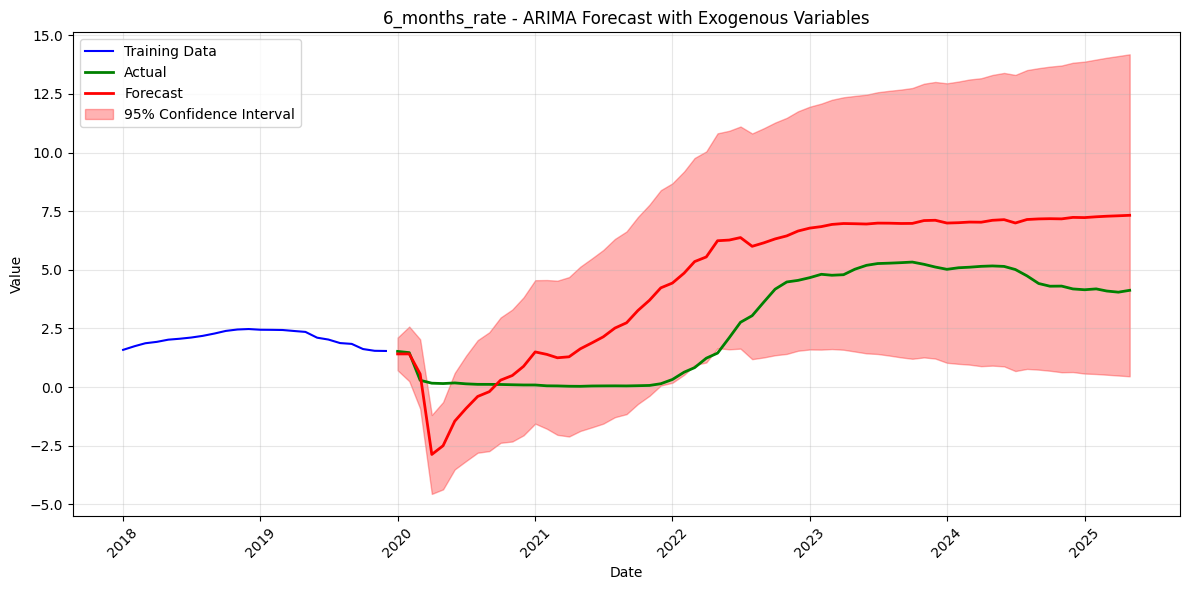


Forecasting: CPI

CPI Stationarity Test:
ADF Statistic: 0.230335
p-value: 0.973913
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 3195.3774554427982
Trying ARIMA order: (0,0,1)
  Success: AIC = -293.84701679263173
Trying ARIMA order: (0,0,2)
  Success: AIC = -292.3805261807883
Trying ARIMA order: (0,0,3)
  Success: AIC = -285.31291436976613
Trying ARIMA order: (0,1,0)
  Success: AIC = -93.73787856300902
Trying ARIMA order: (0,1,1)
  Success: AIC = -201.19442613792165
Trying ARIMA order: (0,1,2)
  Success: AIC = -247.1652157039024
Trying ARIMA order: (0,1,3)
  Success: AIC = -254.36836091485526
Trying ARIMA order: (0,2,0)
  Success: AIC = 355.9008025104285
Trying ARIMA order: (0,2,1)
  Success: AIC = -72.97084752751053
Trying ARIMA order: (0,2,2)
  Success: AIC = -74.52533667141631
Trying ARIMA order: (0,2,3)
  Success: AIC = -95.52940656947985
Trying ARIMA order: (1,0,0)
  Success: AIC = -291.38440368633024
Trying ARIMA order: (1,0,1)
  Success: AIC = -291.93845

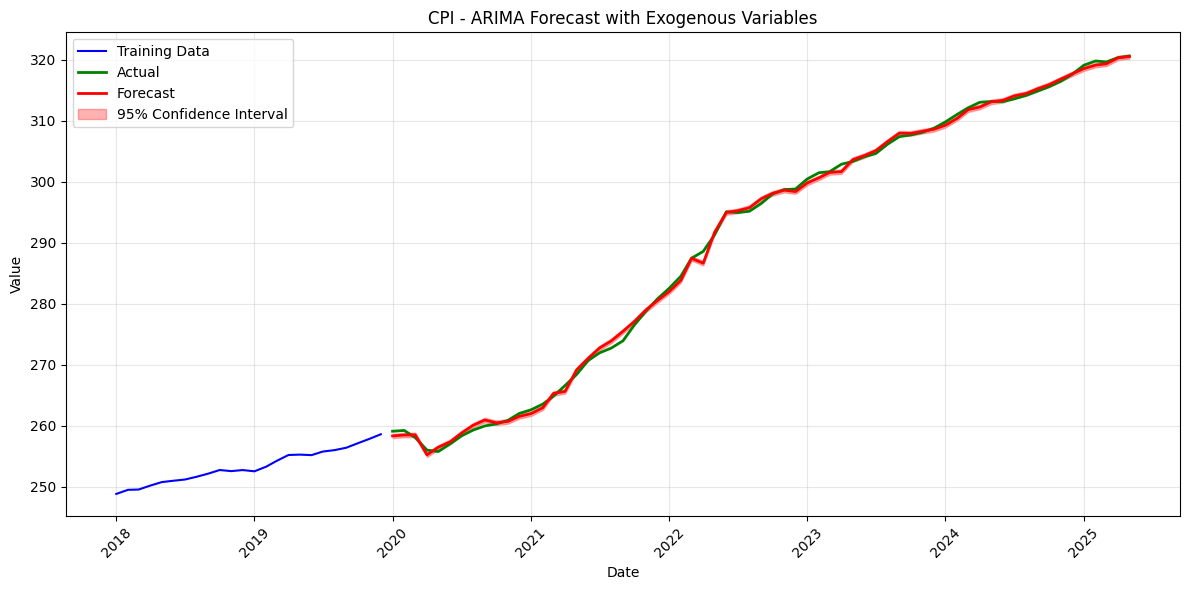


Forecasting: INDPRO

INDPRO Stationarity Test:
ADF Statistic: -0.970779
p-value: 0.763772
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 3312.687021327341
Trying ARIMA order: (0,0,1)
  Success: AIC = -214.28704244806306
Trying ARIMA order: (0,0,2)
  Success: AIC = -225.1308201401206
Trying ARIMA order: (0,0,3)
  Success: AIC = -185.76421826509082
Trying ARIMA order: (0,1,0)
  Success: AIC = -54.460705407262154
Trying ARIMA order: (0,1,1)
  Success: AIC = -120.34199696164902
Trying ARIMA order: (0,1,2)
  Success: AIC = -142.33128598280408
Trying ARIMA order: (0,1,3)
  Success: AIC = -173.3720354870635
Trying ARIMA order: (0,2,0)
  Success: AIC = 521.7552429160553
Trying ARIMA order: (0,2,1)
  Success: AIC = -10.129110047823694
Trying ARIMA order: (0,2,2)
  Success: AIC = -29.57705520885
Trying ARIMA order: (0,2,3)
  Success: AIC = -39.80220501478939
Trying ARIMA order: (1,0,0)
  Success: AIC = -229.67581201328278
Trying ARIMA order: (1,0,1)
  Success: AIC = -228.

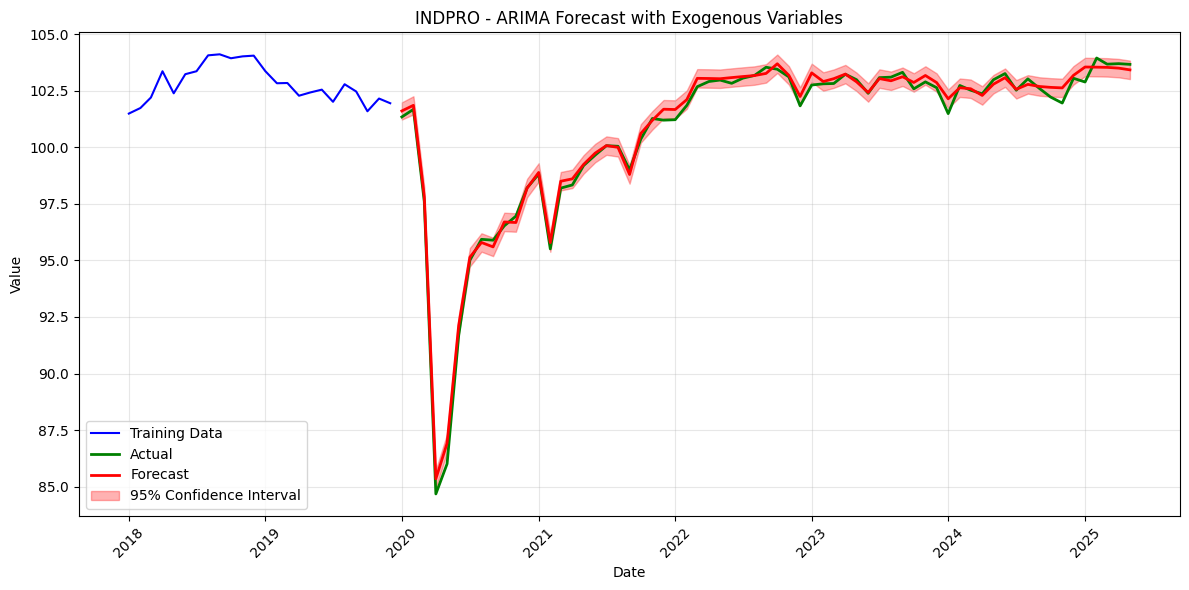


Forecasting: 10_year_rate

10_year_rate Stationarity Test:
ADF Statistic: -0.897583
p-value: 0.788767
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 2432.2135626892723
Trying ARIMA order: (0,0,1)
  Success: AIC = 2045.8868893624137
Trying ARIMA order: (0,0,2)
  Success: AIC = 1906.8516505603418
Trying ARIMA order: (0,0,3)
  Success: AIC = 1614.1750802342544
Trying ARIMA order: (0,1,0)
  Success: AIC = 210.2378242567831
Trying ARIMA order: (0,1,1)
  Success: AIC = 155.33112762479848
Trying ARIMA order: (0,1,2)
  Success: AIC = 149.15562994854287
Trying ARIMA order: (0,1,3)
  Success: AIC = 151.10860034980033
Trying ARIMA order: (0,2,0)
  Success: AIC = 455.9482177150742
Trying ARIMA order: (0,2,1)
  Success: AIC = 234.59800083063354
Trying ARIMA order: (0,2,2)
  Success: AIC = 191.3402893178444
Trying ARIMA order: (0,2,3)
  Success: AIC = 191.853451812773
Trying ARIMA order: (1,0,0)
  Success: AIC = 786.3905229070806
Trying ARIMA order: (1,0,1)
  Success: AIC = 6

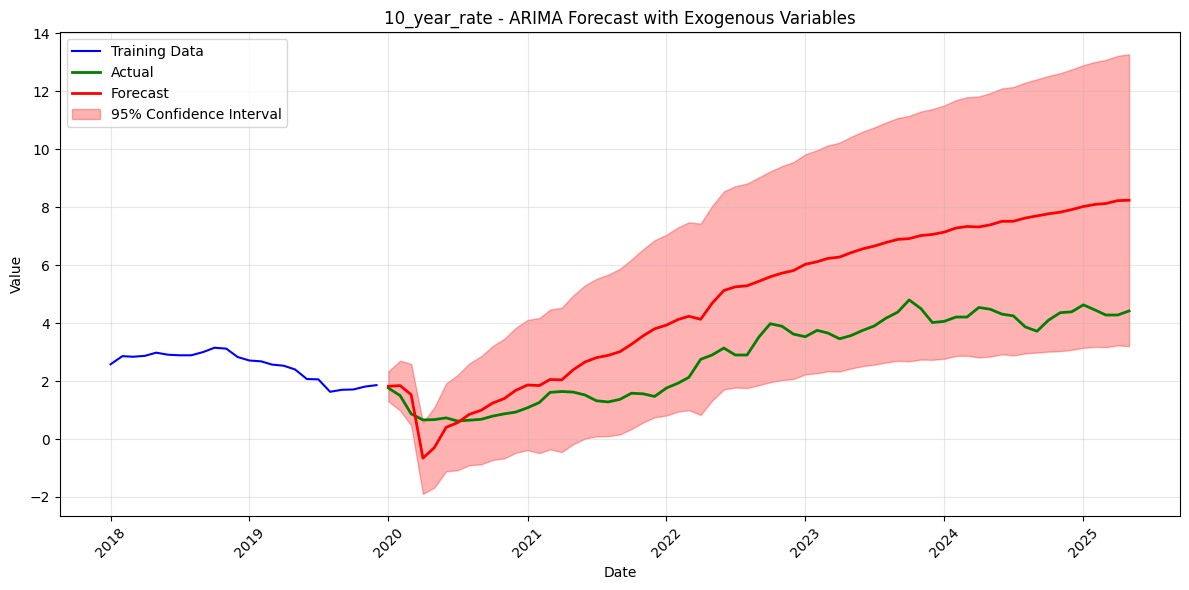


Forecasting: share_price

share_price Stationarity Test:
ADF Statistic: -0.059505
p-value: 0.953326
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 2988.364467824883
Trying ARIMA order: (0,0,1)
  Success: AIC = -803.4990695396451
Trying ARIMA order: (0,0,2)
  Success: AIC = -1000.1014915512612
Trying ARIMA order: (0,0,3)
  Success: AIC = -1043.3921552049774
Trying ARIMA order: (0,1,0)
  Success: AIC = -1976.2416767012485
Trying ARIMA order: (0,1,1)
  Success: AIC = -2011.000147772635
Trying ARIMA order: (0,1,2)
  Success: AIC = -2010.820467639618
Trying ARIMA order: (0,1,3)
  Success: AIC = -2008.4048558962027
Trying ARIMA order: (0,2,0)
  Success: AIC = -1707.3414551217197
Trying ARIMA order: (0,2,1)
  Success: AIC = -1894.9014119405388
Trying ARIMA order: (0,2,2)
  Success: AIC = -1925.7564056119872
Trying ARIMA order: (0,2,3)
  Success: AIC = -1926.0557619613369
Trying ARIMA order: (1,0,0)
  Success: AIC = -1615.566097314158
Trying ARIMA order: (1,0,1)
  Succe

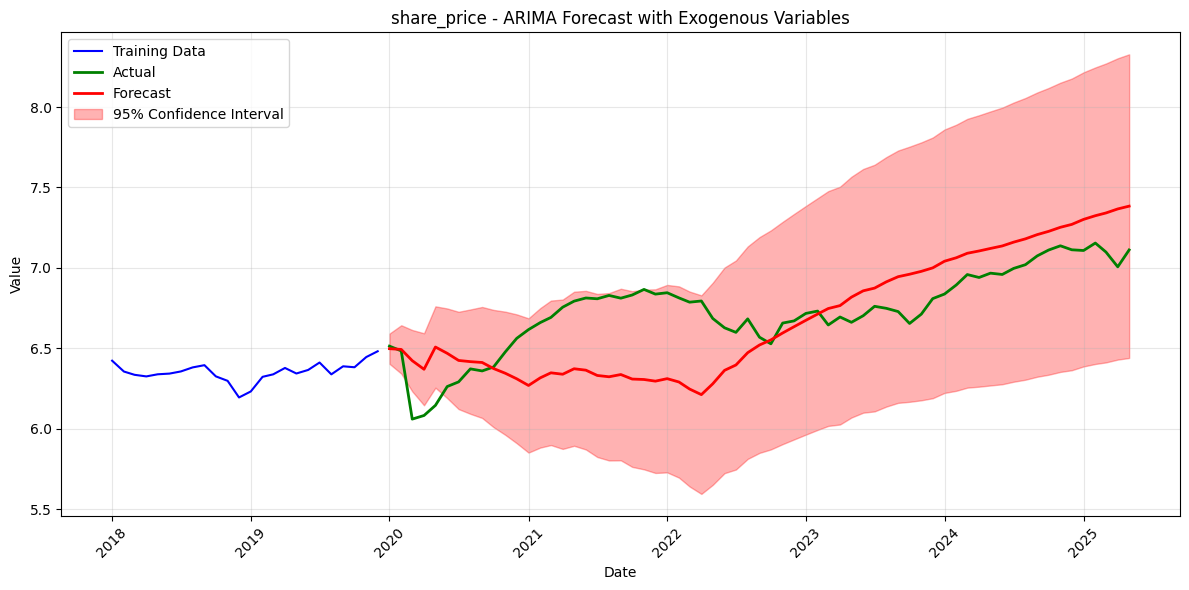


Forecasting: unemployment_rate

unemployment_rate Stationarity Test:
ADF Statistic: -3.046251
p-value: 0.030795
Series is stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 2052.360647235641
Trying ARIMA order: (0,0,1)
  Success: AIC = -1479.8818910867074
Trying ARIMA order: (0,0,2)
  Success: AIC = -1486.7748846645745
Trying ARIMA order: (0,0,3)
  Success: AIC = -1479.5968042097684
Trying ARIMA order: (0,1,0)
  Success: AIC = -1305.08859999216
Trying ARIMA order: (0,1,1)
  Success: AIC = -1382.5956535638811
Trying ARIMA order: (0,1,2)
  Success: AIC = -1407.4479170390114
Trying ARIMA order: (0,1,3)
  Success: AIC = -1421.9434956528203
Trying ARIMA order: (0,2,0)
  Success: AIC = -724.0601460458729
Trying ARIMA order: (0,2,1)
  Success: AIC = -1256.0085261692127
Trying ARIMA order: (0,2,2)
  Success: AIC = -1300.3037207962689
Trying ARIMA order: (0,2,3)
  Success: AIC = -1298.1070217159318
Trying ARIMA order: (1,0,0)
  Success: AIC = -1487.1266222178565
Trying ARIMA order: (1,0,1

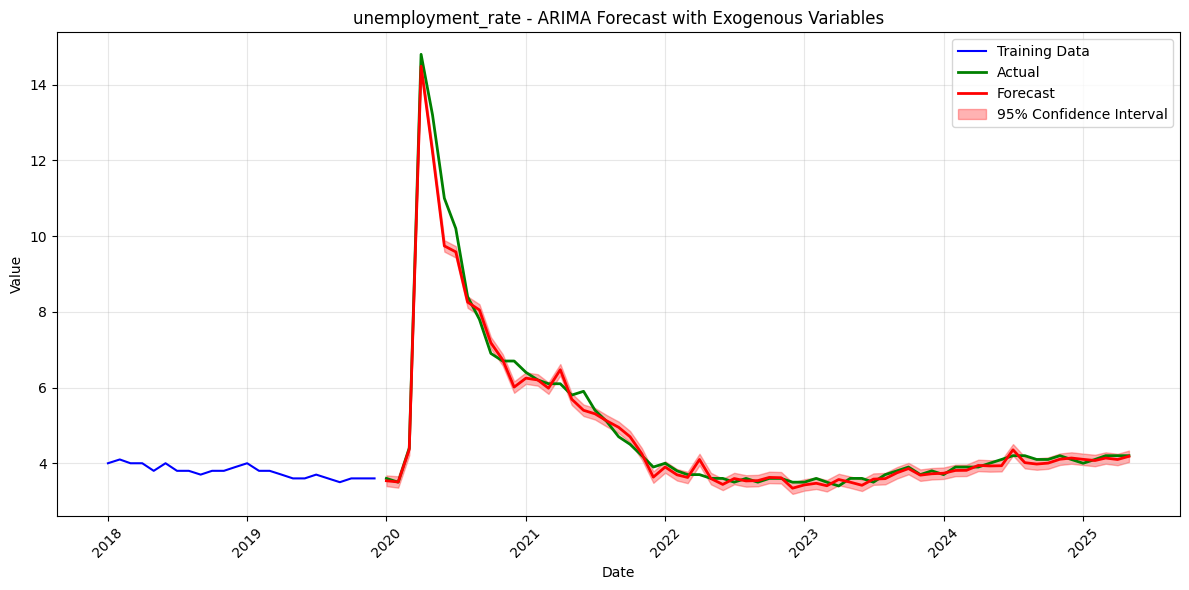


Forecasting: PPI

PPI Stationarity Test:
ADF Statistic: 0.191008
p-value: 0.971753
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 3243.8884831888863
Trying ARIMA order: (0,0,1)
  Success: AIC = 3021.8759177520424
Trying ARIMA order: (0,0,2)
  Success: AIC = 2909.638480058651
Trying ARIMA order: (0,0,3)
  Success: AIC = 2895.6226042147605
Trying ARIMA order: (0,1,0)
  Success: AIC = 2893.173751741965
Trying ARIMA order: (0,1,1)
  Success: AIC = 2868.4285822476395
Trying ARIMA order: (0,1,2)
  Success: AIC = 2833.6506796475405
Trying ARIMA order: (0,1,3)
  Success: AIC = 2835.4572970130257
Trying ARIMA order: (0,2,0)
  Success: AIC = 3024.5361372264074
Trying ARIMA order: (0,2,1)
  Success: AIC = 2940.5765100037015
Trying ARIMA order: (0,2,2)
  Success: AIC = 2897.254285392757
Trying ARIMA order: (0,2,3)
  Success: AIC = 2843.938288610227
Trying ARIMA order: (1,0,0)
  Success: AIC = 2861.057057633764
Trying ARIMA order: (1,0,1)
  Success: AIC = 2858.3995661965037


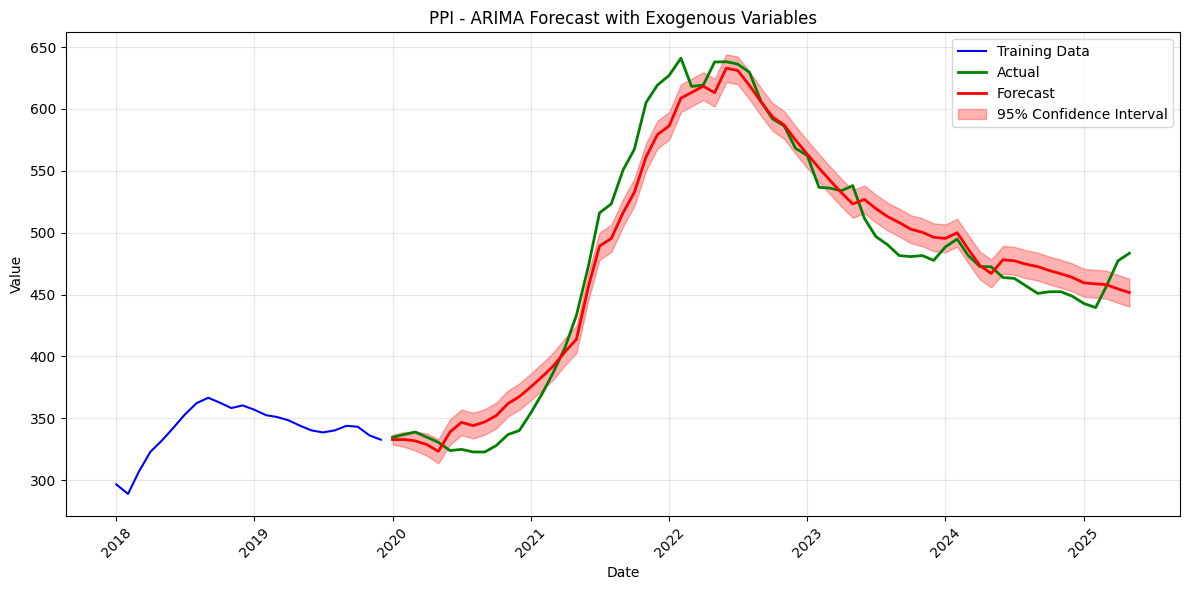


Forecasting: OECD_CLI_index

OECD_CLI_index Stationarity Test:
ADF Statistic: -6.053841
p-value: 0.000000
Series is stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 2527.3685848074697
Trying ARIMA order: (0,0,1)
  Success: AIC = 1669.3283846054605
Trying ARIMA order: (0,0,2)
  Success: AIC = 1594.293107105439
Trying ARIMA order: (0,0,3)
  Success: AIC = 1309.5458286818732
Trying ARIMA order: (0,1,0)
  Success: AIC = -222.53672018536315
Trying ARIMA order: (0,1,1)
  Success: AIC = -934.6110268156718
Trying ARIMA order: (0,1,2)
  Success: AIC = -1329.4505413625147
Trying ARIMA order: (0,1,3)
  Success: AIC = -1169.54387657629
Trying ARIMA order: (0,2,0)
  Success: AIC = -1698.0141116083678
Trying ARIMA order: (0,2,1)
  Success: AIC = -2432.767521012454
Trying ARIMA order: (0,2,2)
  Success: AIC = -2936.1745509368284
Trying ARIMA order: (0,2,3)
  Success: AIC = -3143.377988830027
Trying ARIMA order: (1,0,0)
  Success: AIC = 472.68625407854154
Trying ARIMA order: (1,0,1)
  Success:

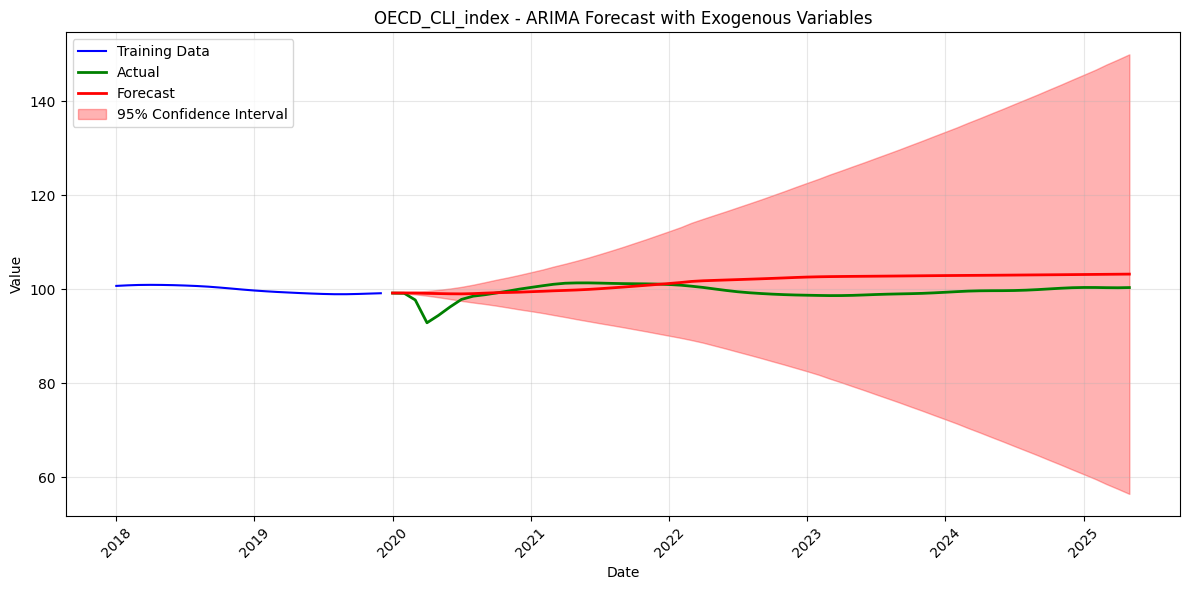


Forecasting: CSI_index

CSI_index Stationarity Test:
ADF Statistic: -3.389553
p-value: 0.011320
Series is stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 4541.572118466642
Trying ARIMA order: (0,0,1)
  Success: AIC = 4108.570222920016
Trying ARIMA order: (0,0,2)
  Success: AIC = 3911.526808066479
Trying ARIMA order: (0,0,3)
  Success: AIC = 3847.8951906008774
Trying ARIMA order: (0,1,0)
  Success: AIC = 3485.6686856846495
Trying ARIMA order: (0,1,1)
  Success: AIC = 3485.5284219234923
Trying ARIMA order: (0,1,2)
  Success: AIC = 3474.4213146975735
Trying ARIMA order: (0,1,3)
  Success: AIC = 3472.6741910363726
Trying ARIMA order: (0,2,0)
  Success: AIC = 3936.105740597196
Trying ARIMA order: (0,2,1)
  Success: AIC = 3490.229056556411
Trying ARIMA order: (0,2,2)
  Success: AIC = 3491.5803169369765
Trying ARIMA order: (0,2,3)
  Success: AIC = 3480.5291885516162
Trying ARIMA order: (1,0,0)
  Success: AIC = 3656.3368215488663
Trying ARIMA order: (1,0,1)
  Success: AIC = 3662.06114

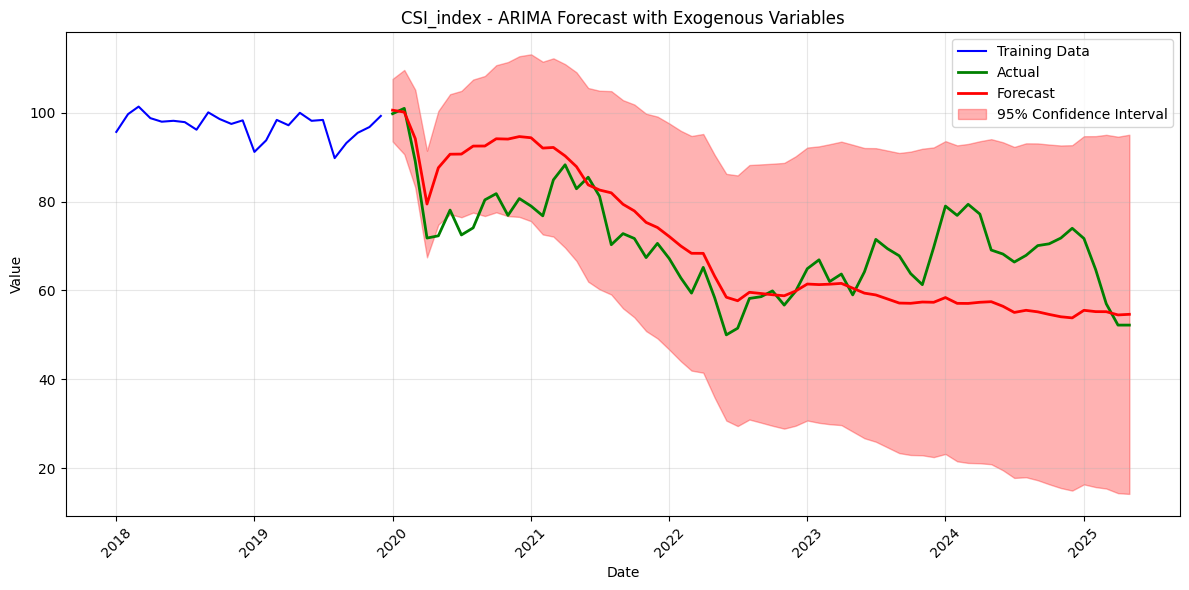


Forecasting: gdp_per_capita

gdp_per_capita Stationarity Test:
ADF Statistic: -0.060547
p-value: 0.953229
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 9763.566354975948
Trying ARIMA order: (0,0,1)
  Success: AIC = 9137.926526282754
Trying ARIMA order: (0,0,2)
  Success: AIC = 8704.626236676972
Trying ARIMA order: (0,0,3)
  Success: AIC = 8546.688499322727
Trying ARIMA order: (0,1,0)
  Success: AIC = 7414.733516924704
Trying ARIMA order: (0,1,1)
  Success: AIC = 7186.9374097167
Trying ARIMA order: (0,1,2)
  Success: AIC = 7001.339552708855
Trying ARIMA order: (0,1,3)
  Success: AIC = 6998.231659660347
Trying ARIMA order: (0,2,0)
  Success: AIC = 7133.071943429249
Trying ARIMA order: (0,2,1)
  Success: AIC = 7135.05006148824
Trying ARIMA order: (0,2,2)
  Success: AIC = 7136.077319340337
Trying ARIMA order: (0,2,3)
  Success: AIC = 6996.022678599151
Trying ARIMA order: (1,0,0)
  Success: AIC = 7463.550079551882
Trying ARIMA order: (1,0,1)
  Success: AIC = 8108.44

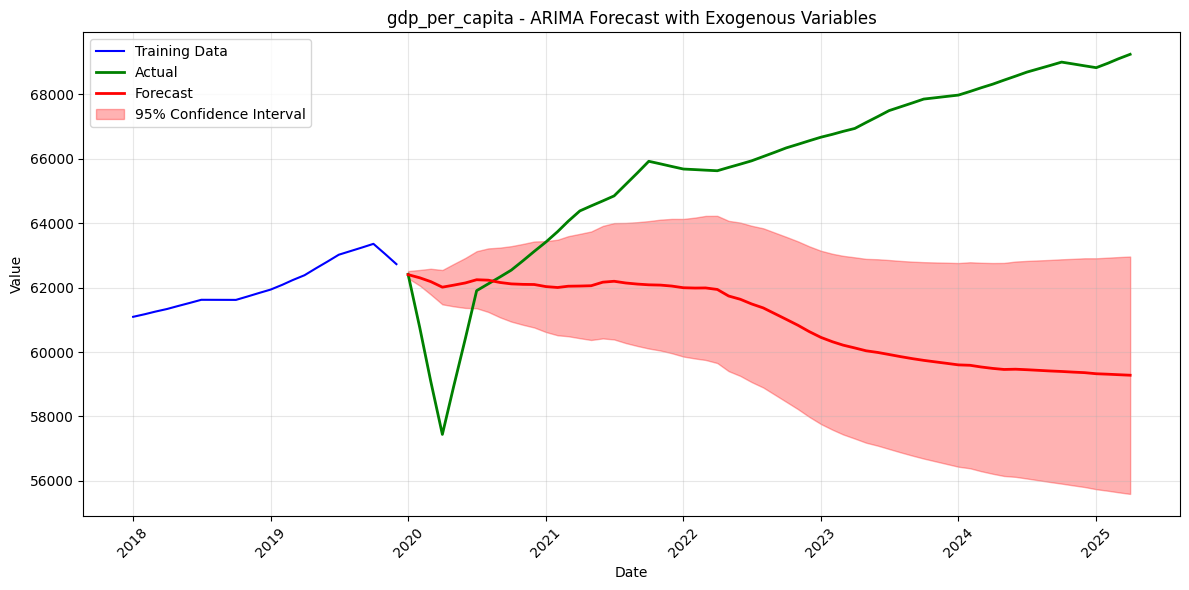

In [8]:
all_results, forecasted_values, train_data, test_data = run_time_series_forecasting(dim_reduced_df, financial_indicators)


In [9]:

# Prepare summary table
metrics_list = []

for indicator, res in all_results.items():
    metrics_list.append({
        'Indicator': indicator,
        'MAE': res['mae'],
        'RMSE': res['rmse'],
        'MAPE_%': res['mape']
    })

metrics_df = pd.DataFrame(metrics_list).set_index('Indicator')

print("\nForecast Performance Metrics:")
print(metrics_df.round(4))


Forecast Performance Metrics:
                         MAE       RMSE     MAPE_%
Indicator                                         
1_year_rate              NaN        NaN        NaN
3_months_rate         3.1487     3.5099  1364.2480
6_months_rate         2.2363     2.4994   870.7745
CPI                   0.5020     0.6150     0.1768
INDPRO                0.2327     0.3000     0.2347
10_year_rate          2.0738     2.3638    75.1472
share_price           0.2400     0.2905     3.5592
unemployment_rate     0.1639     0.2728     2.9516
PPI                  15.7318    19.2420     3.4021
OECD_CLI_index        2.4011     2.7964     2.4255
CSI_index             8.8223    10.8183    12.3579
gdp_per_capita     5320.9359  6162.4168     7.9353


In [10]:
dim_reduced_df.columns

Index(['Unnamed: 0', 'date', '1_year_rate', '3_months_rate', '6_months_rate',
       'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate',
       'PPI', 'OECD_CLI_index', 'CSI_index', 'gdp_per_capita',
       'seasonally_adjusted_CPI', 'CPI_trend',
       'seasonally_adjusted_unemployment_rate', 'INDPRO_trend',
       'seasonally_adjusted_INDPRO', 'PPI_trend', 'recession_probability',
       'unemployment_rate_trend', 'seasonally_adjusted_PPI', 'Year',
       '3_month_recession_probability', '6_month_recession_probability',
       '1_month_recession_probability', 'anomaly_INDPRO', 'Month_Number',
       'anomaly_3_months_rate', 'Quarter_Number', 'anomaly_6_months_rate',
       'anomaly_1_year_rate', 'anomaly_10_year_rate',
       'anomaly_unemployment_rate', 'anomaly_PPI', 'anomaly_CPI',
       'anomaly_share_price', '1_year_rate_acf1_original',
       '1_year_rate_sumsq_acf_original', '1_year_rate_acf1_diff1',
       '1_year_rate_sumsq_acf_diff1', '1_year_rate_acf1_diff

In [14]:
# Extract only the fitted models
fitted_models = {indicator: res['model'] for indicator, res in all_results.items() if res is not None}

# Export to pickle
with open("arima_models.pkl", "wb") as f:
    pickle.dump(fitted_models, f)

print(f"✅ Exported {len(fitted_models)} ARIMA models to arima_models.pkl")

✅ Exported 12 ARIMA models to arima_models.pkl
